<a href="https://colab.research.google.com/github/hideaki-kyutech/softcomp2024/blob/main/CNN_FashionMNIST2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN(Convolutional Neural Network)による画像分類

## 準備
### モジュールのインポート
実行時間を計測するために`datetime`モジュールをインポートしています。

In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

### データセットのロード
FasshonMNISTと呼ばれる洋服の画像のデータセットを用います。

In [4]:
train_dataset = torchvision.datasets.FashionMNIST(
    root='.',
    train=True,
    transform=transforms.ToTensor(),
    download=True)

ロードしたデータの最大値は255です。1ピクセルが8ビットの階調値で表現されているので、255は白になります。

In [5]:
train_dataset.data.max()

tensor(255, dtype=torch.uint8)

データのサイズは$60000\times28\times28$です。画素数$28\times28$の画像が60000枚登録されています。

In [6]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

targets属性には各画像のクラスラベルが設定されています。
画像の見た目や各クラスの意味について興味があれば[こちら](https://atmarkit.itmedia.co.jp/ait/articles/2005/28/news016.html)を参照してみてください。

In [7]:
train_dataset.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

次のコードはクラスラベルとしてどんな数字が用いられているか、またそれぞれのクラスに何個のデータが含まれているかを調べたコードです。
0から9までの数字が用いられているので、クラス数は10であることがわかります。
また、それぞれのクラスは6000個のデータで構成されていることがわかります。

In [31]:
class_labels, num_in_class = torch.unique(train_dataset.targets, return_counts=True)
print(class_labels)
print(num_in_class)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])


テストデータセットをロードします。`train`属性を`False`に設定することで、テストデータのロードになります。

In [8]:
test_dataset = torchvision.datasets.FashionMNIST(
    root='.',
    train=False,
    transform=transforms.ToTensor(),
    download=True)

In [24]:
test_dataset.data.shape

torch.Size([10000, 28, 28])

`set`関数は引数で渡したものを集合に変換します。集合は重複した要素を持たないので、異なるクラスラベルの値が1つずつになります。それを'len'関数に渡すことで、クラス数を読み出すことができます。

In [9]:
# number of classes
K = len(set(train_dataset.targets.numpy()))
print("number of classes:", K)

number of classes: 10


In [32]:
class_labels, num_in_class = torch.unique(test_dataset.targets, return_counts=True)
print(class_labels)
print(num_in_class)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])


## CNNクラスの定義



In [10]:
# Define the model
class CNN(nn.Module):
  def __init__(self, K):
    super().__init__()
    #super(CNN, self).__init__()
    self.conv_layers = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
      nn.ReLU(),
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
      nn.ReLU(),
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
      nn.ReLU()
    )
    # https://theano-pymc.readthedocs.io/en/latest/tutorial/conv_arithmetic.html
    # "No zero padding, non-unit strides"
    # https://pytorch.org/docs/stable/nn.html
    self.dense_layers = nn.Sequential(
      nn.Dropout(0.2),
      nn.Linear(128 * 2 * 2, 512),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(512, K)
    )

  def forward(self, X):
    out = self.conv_layers(X)
    out = out.view(out.size(0), -1)
    out = self.dense_layers(out)
    return out

In [11]:
# Instantiate the model
model = CNN(K)

In [ ]:
# The same model! Using the newly introduced "Flatten"
# model = nn.Sequential(
#     nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
#     nn.ReLU(),
#     nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
#     nn.ReLU(),
#     nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
#     nn.ReLU(),
#     nn.Flatten(),
#     nn.Dropout(0.2),
#     nn.Linear(128 * 2 * 2, 512),
#     nn.ReLU(),
#     nn.Dropout(0.2),
#     nn.Linear(512, K)
# )


In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [13]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [14]:
# Data loader
# Useful because it automatically generates batches in the training loop
# and takes care of shuffling

batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [15]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    model.train()
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_loader:
      # move data to GPU
      inputs, targets = inputs.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading

    model.eval()
    test_loss = []
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, Duration: {dt}')

  return train_losses, test_losses

In [16]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_loader, test_loader, epochs=15)

Epoch 1/15, Train Loss: 0.6561,       Test Loss: 0.4802, Duration: 0:00:10.902547
Epoch 2/15, Train Loss: 0.4308,       Test Loss: 0.3978, Duration: 0:00:09.702390
Epoch 3/15, Train Loss: 0.3716,       Test Loss: 0.3814, Duration: 0:00:09.187692
Epoch 4/15, Train Loss: 0.3351,       Test Loss: 0.3373, Duration: 0:00:09.652018
Epoch 5/15, Train Loss: 0.3082,       Test Loss: 0.3286, Duration: 0:00:10.912596
Epoch 6/15, Train Loss: 0.2838,       Test Loss: 0.3080, Duration: 0:00:09.810023
Epoch 7/15, Train Loss: 0.2665,       Test Loss: 0.3001, Duration: 0:00:09.777657
Epoch 8/15, Train Loss: 0.2474,       Test Loss: 0.3023, Duration: 0:00:10.394700
Epoch 9/15, Train Loss: 0.2363,       Test Loss: 0.3028, Duration: 0:00:09.392571
Epoch 10/15, Train Loss: 0.2197,       Test Loss: 0.2951, Duration: 0:00:09.813958
Epoch 11/15, Train Loss: 0.2074,       Test Loss: 0.2999, Duration: 0:00:09.801886
Epoch 12/15, Train Loss: 0.1972,       Test Loss: 0.2855, Duration: 0:00:09.879547
Epoch 13/15, 

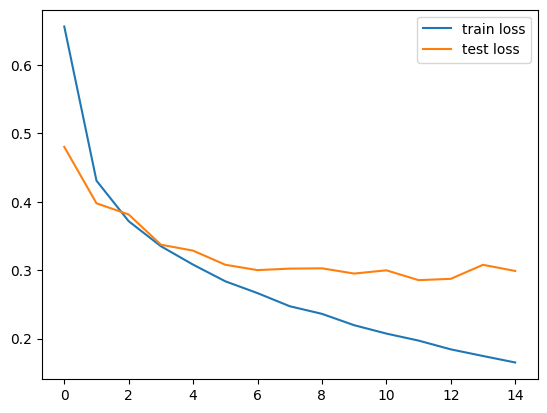

In [17]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()


In [18]:
# Accuracy

model.eval()
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9582, Test acc: 0.9001


In [19]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion matrix, without normalization
[[855   2  30  15   3   1  87   0   7   0]
 [  2 978   1  13   2   0   3   0   1   0]
 [ 13   0 834  13  66   0  69   0   5   0]
 [ 12   7  19 910  32   0  19   0   1   0]
 [  0   1  31  35 858   0  72   0   3   0]
 [  0   0   0   1   0 961   0  20   5  13]
 [ 98   1  67  23  90   0 709   0  12   0]
 [  0   0   0   0   0   9   0 969   0  22]
 [  3   1   3   3   7   1   5   4 971   2]
 [  1   0   0   0   0   7   0  36   0 956]]


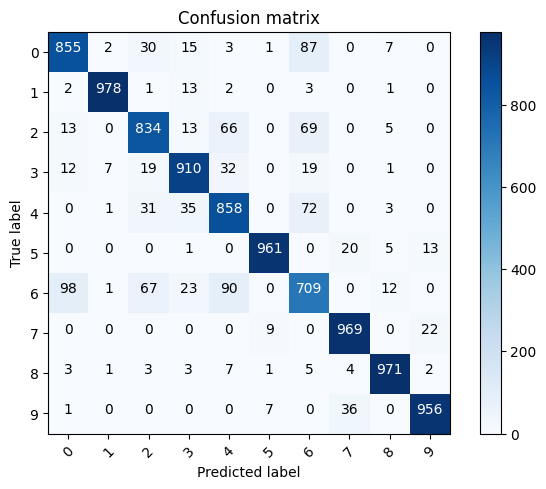

In [20]:
# get all predictions in an array and plot confusion matrix

x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])
for inputs, targets in test_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  _, predictions = torch.max(outputs, 1)

  # update p_test
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))


In [21]:
# Label mapping
labels = '''T-shirt/top
Trouser
Pullover
Dress
Coat
Sandal
Shirt
Sneaker
Bag
Ankle boot'''.split("\n")


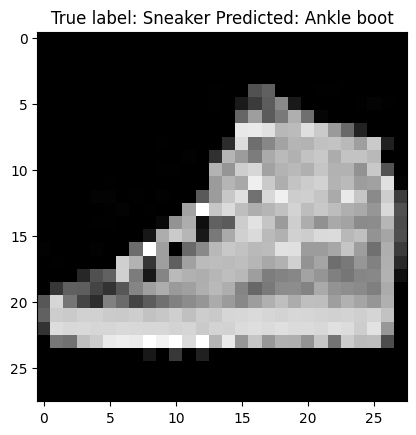

In [22]:
# Show some misclassified examples
p_test = p_test.astype(np.uint8)
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i].reshape(28,28), cmap='gray')
plt.title("True label: %s Predicted: %s" % (labels[y_test[i]], labels[p_test[i]]));

Fashion-MNISTの1枚の画像はグレースケール(0〜255)、28x28 pixです。
学習データセットは60,000枚、テストデータセットは10,000枚の画像が準備されています。
プログラムの中でわかる通り、学習データは各クラス6000枚の画像が準備されています。
以上を踏まえて、次の2つの課題についてレポートしてください。

1.   各クラスの学習データ数が 1枚, 10枚, 100枚, 1000枚, 6000枚の時の汎化性能（テストデータに対する精度）を評価せよ。
2.   各クラスの学習データ数に偏りがあるときの汎化性能を評価せよ。（例：特定のあるクラス: 100枚、他のクラスは6000枚）


